### Process Flow of Project
The steps we followed to implement the project are as follows:

- Data pre-processing such as reading in files and removing punctuations
- Converting text into sets using n-grams
- Min-hashing the document sets to smaller signatures
- LSH to find similar documents(codefiles)
- Comparing LSH with Jaccard Similarity

### Importing the libraries

In [1]:
import os
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
from clean.clean import clean_data
from featurize.featurize import featurize_data, reduce_features
from lsh.lsh import create_lsh_model, find_corpus_neighbors, calculate_distance
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

### Loading the data
The dataset we will be detecting plagiarism for consists of java codefiles which we will load into a pandas dataframe

In [2]:
def pull_data(folder_name) -> DataFrame:
    data = dict()
    for subfolder_name in os.listdir(f'./data/{folder_name}'):
        if subfolder_name == '.DS_Store':
            continue
        lines = list()
        for file_name in os.listdir(f'./data/{folder_name}/{subfolder_name}'):
            with open(f'./data/{folder_name}/{subfolder_name}/{file_name}', 'r') as file:
                for line in file:
                    lines.append(line)
        entry = "".join(lines)
        data[subfolder_name] = entry
    df = DataFrame.from_dict(data=data, orient='index', columns=["text"])
    return df

In [3]:
folder_name = 'A1'
data = pull_data(folder_name)
data = clean_data(data)
df = data.reset_index(drop=True)

In [4]:
#view the data
df.head(5)

,text,rowIndex
0,class for a tree node class mynode int issafe...,024
1,class for a tree node class mynode you may us...,023
2,class for a tree node class mynode you may us...,015
3,class for a tree node class mynode private in...,012
4,class for a tree node class mynode you may us...,079


The data has been loaded and a sample of the dataset is shown above

## Step 1: Shingling the documents
### Convert Documents to sets using n-grams 

In order for the text to compared, we must convert it into a format that represents the content of the text. Here, we will be creating a bag of words to create a n-gram vector for each document. We have used a CountVectorizer to create the n-grams taking a value of n=3. A text corpus based on the source text files is created as a result which is a n-gram of all the content present in these source files. Using the same text corpus, n-gram vectors are created for the suspicious text files which will tell us how many of these n-grams are present in these files. This will then be used to compare documents.

In [5]:
corpus = df['text']
n=3
vectorizer = CountVectorizer(stop_words='english',ngram_range=(n,n))
# Encode the Document
X = vectorizer.fit_transform(corpus)
vectorizer.get_feature_names_out()

array(['10 safetravel start', '1000 boolean mytree',
       '1000 citynode citytree', ..., 'yes traversing root',
       'yes visit start', 'yield path safe'], dtype=object)

#### One-Hot encoding
We will one-hot encode the shingles as that will be required in our Min hashing function

In [6]:
# Transformation using one-hot encoding:
df_transform = DataFrame(X.toarray(),columns=vectorizer.get_feature_names_out())
df_transform.where(df_transform <= 1, 1, inplace=True)
df_transform.index = list(df["rowIndex"])
df_transform_T = df_transform.T

In [7]:
print('Dimension of Source Data Frame:',df_transform_T.shape)
sample_bow=np.array(df_transform_T.iloc[:,3])
print(" This is what an n-gram vector for each document looks like ")
print(sample_bow)
print('Length of Document vector:',len(sample_bow))

Dimension of Source Data Frame: (13160, 120)
 This is what an n-gram vector for each document looks like 
[0 0 0 ... 0 0 0]
Length of Document vector: 13160


## Step 2: Min Hashing $\rightarrow $ Converting Large Sets to short Signatures

As We can see the, length of each document vector is pretty huge(13160). It can be expensive to compare two documents directly. The aim of this step is to convert these long document vectors into short signatures which can fit in memory. These signatures must preserve the similarity of documents. That is, if two documents are similar, then their corresponding signatures must also be similar.

We develop signatures of document by hashing the column multiple times and stringing the output values. This hash function is dependent on the similarity metric. We will be using Jaccard similarity to judge similiarity of documents and Min-Hashing is a suitable hash function for Jaccard similiarity.

$$\text{Jaccard Similarity}= \frac{|D1\cap D2|}{|D1\cup D2|}$$

In Min Hashing,we randomly permute the rows of the n-gram vector. The min hash of a document for a given permutation i is the index of the first 1 in the document when permuted.

For a permutation $\pi$ and column vector c, The hash function $h_{\pi}(c)$ is defined as $$h_{\pi}(c)= min_{\pi}\pi(c) $$

We pick k such permutations to generate a signature of length k for a document. But permuting rows can be expensive. Hence we use the concept of row-hashing for one-pass implementation of min Hashing. We pick k hash functions of the form $h_{a,b}(x)=(ax+b)\mod n$ where n is the number of rows. We apply the hash functions row wise and update the signature matrix accordingly to generate the final signature matrix.

Since we wish to preserve similiarity of documents, we need to choose k to be large enough to decrease the expected error. At the same times, the signature should be small enough to fit in memory.

We use $1000$ permutations to generate min-hash signatures of length=$1000$ for each document, which is a $95\%$ smaller than the actual document vector.

In [8]:
num_shingles=df_transform_T.shape[0]
#using h(x)=ax+b%num_shingles 
#generating 1000 values for a and b
numhashes = 1000
a_hash=np.random.choice(range(num_shingles),size=numhashes,replace=False)
b_hash=np.random.choice(range(num_shingles),size=numhashes,replace=False)

#Min-Hash Function that generates a 1000-integer signature for each document.
def min_hash(df,numhashes=1000,a=a_hash,b=b_hash):
    columns=df.shape[1]
    m=np.ones([numhashes,columns])*np.inf
    #row hashing
    for row in range(num_shingles):
        hash=[]
        for i in range(numhashes):
            value=(a[i]*row+b[i])%num_shingles
            hash.append(value)
    
        for column in range(columns):
            if df.iloc[row,column]==1:
                for i in range(numhashes):
                    if hash[i]<m[i][column]:
                        m[i][column]=hash[i]
    return m

In [9]:
#Apply the Min Hash functions
df_transform_min_hash=min_hash(df_transform_T,numhashes).astype(int)

We can view a sample signature below 

In [10]:
def print_signature(doc_id):
    signature=df_transform_min_hash[:,doc_id]
    return ('- '+' - '.join(map(str,signature[:5]))+' ... '+(' - '.join(map(str,signature[-5:])))+' -')
print('Signature of Document 0')
print(print_signature(0))
print('\nLength  of Signature:',len(df_transform_min_hash[:,0]))

Signature of Document 0
- 24 - 5 - 5 - 23 - 1 ... 3 - 82 - 2 - 14 - 14 -

Length  of Signature: 1000


## Step 3: Locality Sensitive Hashing

Using Locality Sensitive Hashing, we can reduce the number of documents we need to check for each document when looking for plaigarism. Instead of checking all files for plaigarism, we only check the files which are found to be similar via LSH.

A disadvantage of LSH is that it might not detect some similar documents, i.e., it produces false negatives. To do this, we break our signature vector into multiple bands, creating several sub-vectors.

We then hash each of these sub-vectors into a set of buckets, if we find that two sub-vectors from two signature vectors collide (end up in the same hash bucket) we take the two full signature vectors as candidate pairs - which we then compare in full with a similarity metric (like Jaccard similarity, cosine similarity, etc).

To divide the signature vector of each document into b buckets of r rows, we find the optimal values of b and r based on a given threshold.


$Algorithm:$
For every possible value of r (i.e. from 1 to the total number of rows in the signature vector), we obtain the value of b using $1/\text{t}^r$. We want the value of $b*r$ to be as close as possible to the number of rows in the signature matrix (the error). The b and r combination which gives us the least error is chosen.

In [11]:
def get_bands_rows(numhashes,threshold):
    min_error=np.inf
    best_r=-1
    for r in range(1,numhashes+1):
        try:
            b=1/(threshold**r)
        except ZeroDivisionError:
            b=np.inf

        error=abs(numhashes-b*r)
        if error < min_error:
            best_r=r
            min_error=error
    band= int(numhashes/best_r)
    return band,best_r

#Calculate band and row values for similiarity=0.5
lsh_bands,lsh_rows=get_bands_rows(numhashes,0.5)
print("Best Values:")
print('Bands:',lsh_bands,', Rows:',lsh_rows)

Best Values:
Bands: 142 , Rows: 7


Visualizing the s-curve using the obtained row and band values.

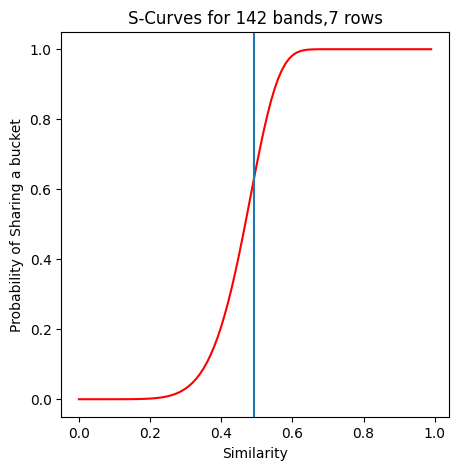

Threshold= [0.493]


In [12]:
r=np.array([lsh_rows])
b=(numhashes/r).astype(int)

s=np.arange(0,1,0.01)
y=np.zeros(len(s))

for i in range(len(r)):
    y=1-(1-s**r)**b
    
threshold=(1/b)**(1/r)

plt.figure(figsize=[5,5])
plt.plot(s,y,color='red')
plt.title('S-Curves for 142 bands,7 rows')
plt.xlabel('Similarity')
plt.ylabel('Probability of Sharing a bucket')
plt.axvline(threshold)
plt.show()
print('Threshold=',np.round(threshold,3)) 

We can see that by using 142 bands and 7 rows in each band, The documents which are more than 50% similar are ~60% likely to share a bucket and documents with >60% similarity are highly likely to share a bucket for atleast one of the bands.

**The value of bands and rows are chosen to minimize the number of false negatives and false positives.**

**Defining the lsh hashing function**

In [13]:
def lsh_hash(x):
    x=np.array(x)
    return np.sum(x**2)%(2**63-1) #31

#building hash_table
#each row is a signature of a document, we have transposed the signature matrix to ensure that
def lsh_corpus(signature_matrix_T,bands=20,rows=5):
    dictionary={}
    signature_matrix=signature_matrix_T.T
    
    for num,signature in enumerate(signature_matrix):
        for i in range(bands):
            # select a band
            mini_signature=signature[i*rows:(i+1)*rows]
            #hash the band
            hash_val=lsh_hash(mini_signature)
            if hash_val not in dictionary:
                dictionary[hash_val]=set()
            #insert document_number into hash table
            dictionary[hash_val].add(num)
    return dictionary



In [14]:
#Use lsh hash table to find documents with similar signatures
def generate_suspicious(dictionary,document,bands=20,rows=5):
    suspicious=set()
    for i in range(bands):
        mini_signature=document[i*rows:(i+1)*rows]
        hash_val=lsh_hash(mini_signature)
        if hash_val in dictionary:
            suspicious=suspicious.union(dictionary[hash_val])
    return suspicious

Building LSH Hash table using signature matrix of Source Documents:

In [15]:
lsh_dict=lsh_corpus(df_transform_min_hash,lsh_bands,lsh_rows)
print("Number of different keys in the LSH dictionary:",len(lsh_dict))
print('\nDictionary Snapshot')
random_keys=np.random.choice([key for key in lsh_dict],size=5)
for key in random_keys:
    print(key,':',lsh_dict[key])

Number of different keys in the LSH dictionary: 14585

Dictionary Snapshot
589146 : {2}
19269 : {102}
43624 : {29}
37821 : {66}
4876 : {94}


After hashing all the source documents into bins (stored as a dictionary), we now know that if we hash a suspicious document to this dictionary, it will be placed in a bin along which contains other documents that are most likely to be similar to it. We can then perform a brute force comparison of the suspicious documents with the source documents present in the same bin to figure out the true similarity and hence whether it is a plagiarism.

## Comparing LSH results with Jaccard similarity

We will now view our results for any document by comparing the Jaccard similarity of documents that are found to be similar by our LSH function

**Defining the function to calculate the Jaccard similarity between signatures of documents:**

In [16]:
def jac_dist(a,b):
    return np.sum(a&b)/np.sum(a|b)

**Function to return the most similar source code document (if one or more exists) given a suspicious document:**

Algorithm for finding the similar documents:
1. generate the hash values bin-wise to obtain the keys for this document
2. fetch the document id's which map to these keys of the hash value 
3. Calculate the jaccard similarity of the two signatures

In [17]:
def compare_similarities(doc_id):
    lsh_results_col_names= ["Source_Code_File", "Suspicious_Doc","Jaccard Similarity"]
    lsh_results_df = pd.DataFrame(columns = lsh_results_col_names)
    lsh_sus_list = generate_suspicious(lsh_dict,df_transform_min_hash[:,48],lsh_bands,lsh_rows)
    if len(lsh_sus_list)==0:
        return "no file found"
    curr_filename = df['rowIndex'][doc_id]
    source_bow = np.array(df_transform_T .iloc[:,doc_id])
    for sus_doc in lsh_sus_list:
        sus_bow=np.array(df_transform_T .iloc[:,sus_doc])
        similarity=jac_dist(sus_bow,source_bow)
        sus_filename = df["rowIndex"][sus_doc]
        lsh_results_df = lsh_results_df.append(pd.Series([curr_filename, sus_filename, similarity], index = lsh_results_col_names), ignore_index=True)
    
    return lsh_results_df

View for a sample document

In [18]:
df1 = compare_similarities(0)

In [19]:
df1

,Source_Code_File,Suspicious_Doc,Jaccard Similarity
0,024,023,0.174721
1,024,073,0.103074
2,024,079,0.169231
3,024,041,0.166667
4,024,018,0.107438
5,024,3-2,0.133971
6,024,083,0.198502
7,024,081,0.198230
8,024,084,0.130258
9,024,086,0.181818
